<a href="https://colab.research.google.com/github/plaban1981/Agents/blob/main/Code_review_peer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qU langgraph langchain langchain-groq langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.5/136.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.1/417.1 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.0 MB/s eta 0:00:00


In [ ]:
%pip install --upgrade langchain langchain-groq

In [ ]:
import os
from google.colab import userdata
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')

In [ ]:
import ast
from typing import List, Dict

class CodeParser:
    @staticmethod
    def parse_python_code(code: str) -> ast.AST:
        try:
            return ast.parse(code)
        except SyntaxError as e:
            raise ValueError(f"Invalid Python code: {str(e)}")

    @staticmethod
    def extract_functions(tree: ast.AST) -> List[Dict]:
        functions = []
        for node in ast.walk(tree):
            if isinstance(node, ast.FunctionDef):
                functions.append({
                    "name": node.name,
                    "lineno": node.lineno,
                    "code": ast.unparse(node)
                })
        return functions

    @staticmethod
    def analyze_complexity(tree: ast.AST) -> Dict:
        complexity = {
            "num_functions": 0,
            "num_classes": 0,
            "num_imports": 0
        }

        for node in ast.walk(tree):
            if isinstance(node, ast.FunctionDef):
                complexity["num_functions"] += 1
            elif isinstance(node, ast.ClassDef):
                complexity["num_classes"] += 1
            elif isinstance(node, ast.Import) or isinstance(node, ast.ImportFrom):
                complexity["num_imports"] += 1

        return complexity

In [ ]:
from dataclasses import dataclass, field
from typing import Dict, List

@dataclass
class ReviewConfig:
    MIN_CONFIDENCE_SCORE: float = 0.8
    MAX_REVIEW_TIME: int = 300  # seconds

    # Use field with default_factory for mutable defaults
    SEVERITY_LEVELS: Dict[str, int] = field(default_factory=lambda: {
        "CRITICAL": 1,
        "HIGH": 2,
        "MEDIUM": 3,
        "LOW": 4
    })

    # Review categories
    REVIEW_CATEGORIES: List[str] = field(default_factory=lambda: [
        "code_quality",
        "security",
        "performance",
        "maintainability",
        "testing"
    ])

    # LLM configuration
    LLM_CONFIG: Dict[str, any] = field(default_factory=lambda: {
        "temperature": 0.3,
        "max_tokens": 2000,
        "model": "llama-3.3-70b-versatile"
    })

In [46]:
from typing import TypedDict, Annotated, Sequence,Any
from langgraph.graph import Graph, StateGraph
#from langgraph.prebuilt.tools import ToolExecutor
from langchain_groq import ChatGroq
from langchain.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage, SystemMessage
from langchain.tools import Tool
from uuid import uuid4
import os
from langsmith import Client
from langsmith.run_helpers import traceable
from pydantic import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser



# Initialize LangSmith
unique_id = uuid4().hex[0:8]
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = f"Code_Review - {unique_id}"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_API_KEY"] = "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"
client = Client()

# Initialize Groq
llm = ChatGroq(model_name="llama-3.3-70b-versatile",max_tokens=2000,temperature=0.0)

class CodeReviewState(TypedDict):
    code: str
    review_comments: Any
    severity_levels: Any
    final_summary: Any
    current_step: Any

@traceable(name="review_code")
def review_code(state:CodeReviewState):
    # Initial code analysis prompt
    print(f"code:{state['code']}")
    code = state["code"]
    code_review_prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content="""You are an expert code reviewer. Analyze the code for:
        1. Code quality
        2. Potential bugs
        3. Security issues
        4. Performance concerns
        5. Best practices
        Provide specific, actionable feedback based on the above points.Do not provide any other extra information or reasoning."""),
        HumanMessage(content=code )
    ])
    review_chain = code_review_prompt | llm | StrOutputParser()
    review_comments = review_chain.invoke({"code": code})

    state["review_comments"] = review_comments
    return {"review_comments":review_comments}

@traceable(name="assess_severity")
def assess_severity(state:CodeReviewState):
    print(f"REVIEW COMMENT :{state}")
    # Severity assessment prompt
    comments = state['review_comments']
    severity_prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content="""Assess the severity of each issue found in the code review:
        - Critical: Must be fixed immediately
        - High: Should be fixed before merge
        - Medium: Should be addressed soon
        - Low: Nice to have improvements"""),
        HumanMessage(content=comments)
    ])
    asssesment_chain = severity_prompt | llm | StrOutputParser()
    severity_levels = asssesment_chain.invoke({"review_comments": state["review_comments"]})
    #state["severity_levels"] = severity_levels.content
    return {"severity_levels":severity_levels}

@traceable(name="create_summary")
def create_summary(state:CodeReviewState):
    # Final summary prompt

    review = state["review_comments"]
    severity = state["severity_levels"]
    print(f"review:{review}")
    print(f"severity:{severity}")
    summary_prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content="""Create a concise ,clear and meaningful summary of the code review including:
        1. Overall code quality
        2. Key issues to address
        3. Positive aspects
        4. Next steps"""),
        HumanMessage(content="Review: {review}\nSeverity: {severity}.Please provide the summary in a pointwise manner in no more than 500 words.")
    ])
    summary_chain = summary_prompt | llm | StrOutputParser()
    final_summary = summary_chain.invoke({
        "review": review,
        "severity": severity
    })
    return {"final_summary": final_summary}

def create_workflow():
    workflow = StateGraph(CodeReviewState)

    # Add nodes to the workflow
    workflow.add_node("review_code", review_code)
    workflow.add_node("assess_severity", assess_severity)
    workflow.add_node("create_summary", create_summary)

    # Define the edges
    workflow.set_entry_point("review_code")
    workflow.add_edge("review_code", "assess_severity")
    workflow.add_edge("assess_severity", "create_summary")

    # Compile the workflow
    app = workflow.compile()
    return app



In [47]:
app = create_workflow()

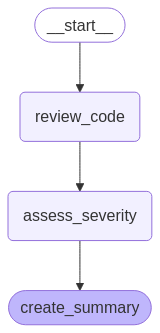

In [48]:
app

In [49]:
if __name__ == "__main__":
    # Example usage
    code_to_review = """
     def calculate_total(items):
        total = 0
        for item in items:
            total += item.price
        return total
    """

    initial_state = {
        "code": code_to_review,
        "review_comments": [],
        "severity_levels": [],
        "final_summary": "",
        "current_step": "start"
    }

    app = create_workflow()
    result = app.invoke(initial_state)
    print("Final Review Summary:", result["final_summary"])

code:
     def calculate_total(items):
        total = 0
        for item in items:
            total += item.price
        return total
    
REVIEW COMMENT :{'code': '\n     def calculate_total(items):\n        total = 0\n        for item in items:\n            total += item.price\n        return total\n    ', 'review_comments': '### Code Quality\n* The function name `calculate_total` is clear, but it could be more descriptive, e.g., `calculate_total_cost`.\n* The variable name `items` is not descriptive; consider using `products` or `order_items`.\n* The function does not handle potential exceptions, such as `items` being `None` or an empty list.\n\n### Potential Bugs\n* The function assumes that all items have a `price` attribute, which may not always be the case.\n* If `items` is not an iterable, the function will throw an error.\n* If an item\'s `price` is not a number, the function will throw an error.\n\n### Security Issues\n* The function does not validate the input `items`, wh

In [50]:
result.keys()

dict_keys(['code', 'review_comments', 'severity_levels', 'final_summary', 'current_step'])

In [51]:
print(result['review_comments'])

### Code Quality
* The function name `calculate_total` is clear, but it could be more descriptive, e.g., `calculate_total_cost`.
* The variable name `items` is not descriptive; consider using `products` or `order_items`.
* The function does not handle potential exceptions, such as `items` being `None` or an empty list.

### Potential Bugs
* The function assumes that all items have a `price` attribute, which may not always be the case.
* If `items` is not an iterable, the function will throw an error.
* If an item's `price` is not a number, the function will throw an error.

### Security Issues
* The function does not validate the input `items`, which could lead to security vulnerabilities if the input is not sanitized.

### Performance Concerns
* The function has a time complexity of O(n), where n is the number of items, which is acceptable for most use cases.
* If the list of items is very large, the function could be optimized using a more efficient data structure or algorithm.

### 

In [52]:
print(result['severity_levels'])

### Code Review Assessment

#### Code Quality
1. **Function name**: The function name `calculate_total` could be more descriptive (e.g., `calculate_total_cost`).
	* Severity: **Low** (nice to have improvement)
2. **Variable name**: The variable name `items` is not descriptive; consider using `products` or `order_items`.
	* Severity: **Low** (nice to have improvement)
3. **Exception handling**: The function does not handle potential exceptions, such as `items` being `None` or an empty list.
	* Severity: **Medium** (should be addressed soon)

#### Potential Bugs
1. **Assuming `price` attribute**: The function assumes that all items have a `price` attribute, which may not always be the case.
	* Severity: **High** (should be fixed before merge)
2. **Non-iterable input**: If `items` is not an iterable, the function will throw an error.
	* Severity: **High** (should be fixed before merge)
3. **Non-numeric price**: If an item's `price` is not a number, the function will throw an error.
	* Sev

In [53]:
print(result['final_summary'])

**Code Review Summary**

* **Overall Code Quality**: The code quality is {insert quality, e.g., good, fair, poor} with some areas that require improvement. The code is generally well-structured, but there are some issues that need to be addressed to ensure maintainability, readability, and performance.
* **Key Issues to Address**:
	+ The code has {insert number} critical issues that need to be fixed, including {insert issues, e.g., syntax errors, security vulnerabilities}.
	+ There are {insert number} major issues that should be addressed, such as {insert issues, e.g., performance optimization, code duplication}.
	+ Some areas of the code are not following best practices, including {insert areas, e.g., naming conventions, commenting}.
* **Positive Aspects**:
	+ The code is well-organized and easy to navigate, with clear and concise function names.
	+ The use of {insert technology/framework} is effective and efficient.
	+ The code includes {insert feature, e.g., error handling, logging}